<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANSAC line in 2D

In this lesson the base of RANSAC (RANdom SAmple Consensus) method is explaned.

RANSAC is a robust method to find geometric shapes in point clouds. Two find a line in two dimensions the following steps are used 

1. select two points random from the point cloud
2. find the equation of line runs through the two points
3. find the number of points which are close to the line
4. if the number of points is larger than the max sofar save it as the best solution so far
5. if the repeptition number not reached go back to 1

This algorithm is not deterministic, if you repeat the steps above you may get different solution. If the number of repetition is high the different solutions will be close to each other.

The algorithm depends on two predefined constants, the maximal distance of the point from the line to be accepted and the number of repetition.

In [ ]:
# Python packages used
import numpy as np                      # for array operations
from matplotlib import pyplot as plt    # for graphic output
from math import sqrt

In [ ]:
# parameters
tolerance = 2.5           # max distance from the plane to accept point
rep = 1000                # number of repetition

The number of repetition is quiet high to get a quasy optimal solution.

We use random numbers to generate 2D points. *n* points are generated close to the line (0.451 x - y + 2 = 0). Other *k* points are generated 

In [ ]:
n = 100                     # number of inliers
k = 200                     # number of outliers
range = 100.0               # range of x, y coordinates
l = [0.451, -1.0, 2.0]      # line equation ax + by + c = 0
x = np.zeros(n+k)
y = np.zeros(n+k)
# points near to the line
x[:n] = np.random.rand(n) * range
y[:n] = -l[0] / l[1] * x[:n] - l[2] / l[1] + (np.random.rand(n) * 2 * tolerance - tolerance)
# outlier points (noise)
x[n:] = np.random.rand(k) * range
y[n:] = np.random.rand(k) * range
points = np.c_[x, y, np.full(n+k, 1.0)] # put together inliers and outliers

Let's display the points and the original line.

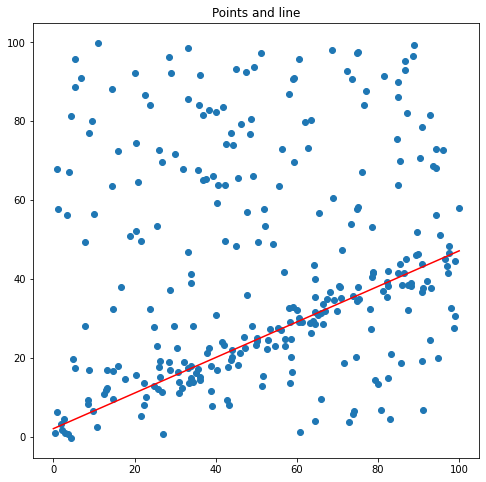

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'r', label='original line')
_ = ax.set_title('Points and line')

In [ ]:
best_n = 0          # number of points on the best fit line so far
best_i = 0          # iteration index of best fit line so far
best_inliers = np.array([]) # indices of inliers of the best fit line so far
for i in np.arange(rep):
    # select two random points
    p = []  # list of random indices for points
    while len(p) != 2:
        p = list(set(np.random.randint(n+k, size=2))) # remove repeated random integers
    p1 = points[p]  # randomly selected points
    x1 = p1[:,0]    # x coordinates
    y1 = p1[:,1]    # y coordinates
    # line equation from the two points using homogenouos coordinates
    l1 = np.array([y1[0] - y1[1], x1[1] - x1[0], x1[0] * y1[1] - x1[1] * y1[0]])
    l1 = l1 / sqrt(l1[0]**2 + l1[1]**2)     # normalize
    # select close points
    inliers = points[np.abs(np.dot(points, l1)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers.copy()
        best_line = l1.copy()
print(f'Best solution after {best_i} repetitions, {best_n} points on line: {best_line}')

Best solution after 924 repetitions, 127 points on line: [ 0.38666082 -0.92222199  3.27787792]


Please run the code block above and notice the small differences in the line parameters.

Finaly let's display the best fitting line.

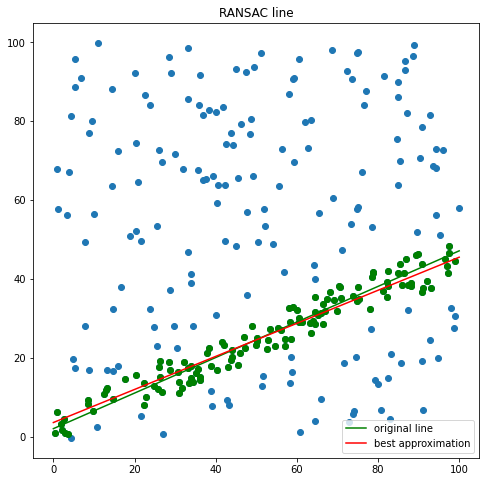

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.scatter(best_inliers[:,0], best_inliers[:,1], c='g')
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'g', label='original line')
ax.plot([0,100], [-best_line[2] / best_line[1], -best_line[0] / best_line[1] * 100 - best_line[2] / best_line[1]], 'r', label='best approximation')
ax.legend()
_ = ax.set_title('RANSAC line')

A folyamat bemutatása animációval:

![ransac](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/ransac/ransac_line_5_48.gif)